# Perguntas de pesquisa

P1 — Comparação de grupos:

Há evidência estatística (α = 0,05) de que transações rotuladas como lavagem apresentam maior valor médio de transação que transações legítimas?

Tipo: Comparação de médias (t-test).

\
P2 — Intervalo de confiança e risco:

O intervalo de confiança de 95% para o valor médio de transações suspeitas exclui valores críticos (ex: acima de 50.000 unidades monetárias)?

Tipo: Intervalo de confiança sobre média.

\
P3 — Correlação significativa:

Existe correlação estatisticamente significativa entre valor da transação e indicadores de risco / frequência de transações?

Tipo: Correlação de Spearman e discussão de causalidade.

\
P4 — Concordância na classificação:

Existe concordância estatisticamente significativa entre a classificação de lavagem atribuída pela LLM e o rótulo real da base IBM?

# Experimento

## Bibliotecas utilizadas

In [2]:
import pandas as pd
import numpy as np

from scipy import stats
import ollama
import json

## Base de dados utilizada (IBM AML)

In [ ]:
# OBS: o limite de tamanho de arquivos no GitHub é 100MB, logo, o arquivo "LI-Small_Trans.csv" foi dividido em 1 e 2. Deve-se unificar as duas partes para utilizar no código

In [3]:
transactions = pd.read_csv("LI-Small_Trans.csv")
accounts = pd.read_csv("LI-Small_accounts.csv")

# Renomeando colunas para reduzir ambiguidade
transactions.columns = [
    "timestamp",
    "from_bank",
    "from_account",
    "to_bank",
    "to_account",
    "amount_received",
    "receiving_currency",
    "amount_paid",
    "payment_currency",
    "payment_format",
    "is_laundering_true"
]

## Variáveis estatisticamente interpretáveis

In [7]:
# Valor absoluto
transactions["amount"] = transactions["amount_paid"].abs()

# Frequência de transações por conta de origem
freq = transactions.groupby("from_account").size()
transactions["tx_frequency"] = transactions["from_account"].map(freq)

transactions.head()

,timestamp,from_bank,from_account,to_bank,to_account,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering_true,amount,tx_frequency
0,2022/09/01 00:08,11,8000ECA90,11,8000ECA90,3195403.00,US Dollar,3195403.00,US Dollar,Reinvestment,0,3195403.00,40
1,2022/09/01 00:21,3402,80021DAD0,3402,80021DAD0,1858.96,US Dollar,1858.96,US Dollar,Reinvestment,0,1858.96,1
2,2022/09/01 00:00,11,8000ECA90,1120,8006AA910,592571.00,US Dollar,592571.00,US Dollar,Cheque,0,592571.00,40
3,2022/09/01 00:16,3814,8006AD080,3814,8006AD080,12.32,US Dollar,12.32,US Dollar,Reinvestment,0,12.32,1
4,2022/09/01 00:00,20,8006AD530,20,8006AD530,2941.56,US Dollar,2941.56,US Dollar,Reinvestment,0,2941.56,42


In [207]:
transactions[["amount", "tx_frequency", "is_laundering_true"]].head()

,amount,tx_frequency,is_laundering_true
0,3195403.00,40,0
1,1858.96,1,0
2,592571.00,40,0
3,12.32,1,0
4,2941.56,42,0


## Rotulagem de risco com a LLM

In [208]:
def classify_transaction(row):
    prompt = f"""
    Analyze the following transaction:

    Amount: {row['amount']}
    Transaction frequency (origin account): {row['tx_frequency']}

    Tasks:
    1. Is this transaction suspicious of money laundering? ('Yes' or 'No')
    2. Assign a risk score from 0 to 10 (Integer)

    Return ONLY valid JSON with:
    is_laundering, risk_score
    """

    response = ollama.chat(
        model="mistral-aml-q4",
        messages=[{"role": "user", "content": prompt}],
        options={"temperature": 0}
    )

    try:
        result = json.loads(response["message"]["content"])
        return pd.Series([
            1 if result["is_laundering"].lower() == "yes" else 0,
            result["risk_score"]
        ])
    except:
        return pd.Series([np.nan, np.nan])


## Aplicação em amostra

In [209]:
transactions['is_laundering_true'].value_counts()

is_laundering_true
0    6920484
1       3565
Name: count, dtype: int64

Dada a natureza altamente desbalanceada da base AML, serão conduzidos dois experimentos complementares. 

Embora a base contenha milhões de transações, a inferência estatística será realizada sobre uma amostra aleatória de tamanho n = 300, suficiente para detectar efeitos de magnitude moderada com nível de significância de 5%.

In [210]:
sample_len = 300

### No primeiro experimento, utilizaremos amostragem aleatória simples, com o objetivo de preservar a distribuição populacional real. 

In [230]:
real_population_sample = transactions.sample(sample_len, random_state=42)

real_population_sample['is_laundering_true'].value_counts()

is_laundering_true
0    300
Name: count, dtype: int64

In [231]:
real_population_sample[["is_laundering", "risk_score"]] = real_population_sample.apply(
    classify_transaction, axis=1
)

real_population_sample.to_csv("real_population_sample_with_llm.csv", index=False)

### No segundo experimento, adotaremos amostragem estratificada (80/20), garantindo representatividade mínima da classe positiva, permitindo análises comparativas e métricas de concordância estatística.

In [ ]:
percentage_laundering = 0.20

n_1 = int(sample_len * percentage_laundering)   # 60
n_0 = sample_len - n_1                          # 240

sample_1 = transactions[transactions['is_laundering_true'] == 1].sample(
    n=n_1, random_state=42
)

sample_0 = transactions[transactions['is_laundering_true'] == 0].sample(
    n=n_0, random_state=42
)

stratified_sample = pd.concat([sample_0, sample_1]) \
           .sample(frac=1, random_state=42) \
           .reset_index(drop=True)


In [177]:
stratified_sample['is_laundering_true'].value_counts()

is_laundering_true
0    240
1     60
Name: count, dtype: int64

In [180]:
stratified_sample[["is_laundering", "risk_score"]] = stratified_sample.apply(
    classify_transaction, axis=1
)

stratified_sample.to_csv("stratified_sample_with_llm.csv", index=False)

## P1 — Comparação de grupos (Teste de hipótese)

### Separação por grupos

In [9]:
laundering = transactions[transactions["is_laundering_true"] == 1]["amount"]
legit = transactions[transactions["is_laundering_true"] == 0]["amount"]

### Teste de normalidade:

Os valores de amount (transações financeiras) costumam ser assimétricos, possuem outliers e têm caudas longas.
Logo, o teste de Shapiro–Wilk provavelmente rejeitará a hipótese de normalidade, ou seja, os dados não seguem uma distribuição normal.

\
Hipótese nula (H₀): os dados seguem uma distribuição normal

Hipótese alternativa (H₁): os dados não seguem distribuição normal

In [233]:
stats.shapiro(laundering.sample(min(50, len(laundering))))

ShapiroResult(statistic=np.float64(0.21933137937544467), pvalue=np.float64(7.69611168348679e-15))

In [234]:
stats.shapiro(legit.sample(min(50, len(legit))))

ShapiroResult(statistic=np.float64(0.12582739095822004), pvalue=np.float64(1.1362748612034193e-15))

statistic = W

pvalue = p

\
🔹 Estatística W ≈ 0.21 e 0.12
- O valor de W varia entre 0 e 1
- Quanto mais próximo de 1, mais normal a distribuição
- Valores muito baixos indicam forte desvio da normalidade

0.21 e 0.12 são extremamente baixos, indicando assimetria pesada, caudas longas e/ou muitos outliers, o que é esperado de valores financeiros.

\
🔹 p-value ≈ 7.69 × 10⁻¹⁵ e 1.37 × 10⁻¹⁵
- Muito menor que qualquer nível de significância comum (0.05, 0.001, 0.0001, por exemplo)

p << 0.05 ⇒ rejeita-se H₀

\
A hipótese de normalidade é rejeitada com evidência extremamente forte.

Como a normalidade não se sustenta nesse caso, devemos usar um teste que não assuma normalidade. Por exemplo, Mann-Whitney, pois é adequado para dados assimétricos/que possuem outliers.

O teste de Shapiro–Wilk indicou violação severa da suposição de normalidade (W = 0.13, p < 0.001). 

Diante disso, optou-se pelo uso do teste não paramétrico de Mann–Whitney U para a comparação entre os grupos.

### Teste Mann–Whitney U

H₀ (nula): a distribuição de laundering não é maior que a de legit (distribuições iguais)

H₁ (alternativa): os valores de laundering (suspeitos) tendem a ser maiores que os de legit (legítimos)

In [ ]:
# Teste unilateral (amount laundering greater legit)
u_stat, p_value = stats.mannwhitneyu(
    laundering, legit, alternative="greater"
)

u_stat, p_value

(np.float64(15161956743.5), np.float64(2.440459742209528e-124))

O valor de p é extremamente pequeno. A probabilidade de observar um resultado assim caso H₀ fosse verdadeira é praticamente zero.

Há evidência extremamente forte de que os valores de laundering são maiores do que os de legit. Portanto, rejeitamos fortemente H₀. 

As observações classificadas como laundering apresentam valores significativamente maiores do que as observações legit. Isto é, transações suspeitas tendem a ter valores mais altos do que transações legítimas, com evidência estatística esmagadora.

## P2 — Intervalo de Confiança (95%)

In [252]:
critical_value = np.percentile(legit, 95)

In [237]:
def bootstrap_ci(data, n_boot=10000, alpha=0.05):
    means = []
    for _ in range(n_boot):
        sample = np.random.choice(data, size=len(data), replace=True)
        means.append(sample.mean())
    return np.percentile(means, [100*alpha/2, 100*(1-alpha/2)])

In [251]:
ci_low, ci_high = bootstrap_ci(laundering.values)

In [250]:
print(f"Percentil 95% das transações legítimas: {critical_value:.2f}")
print(f"IC 95% (bootstrap) das suspeitas: [{ci_low:.2f}, {ci_high:.2f}]")

if ci_low > critical_value:
    print("O intervalo de confiança exclui valores típicos das transações legítimas.")
else:
    print("O intervalo de confiança inclui valores típicos das transações legítimas.")

Percentil 95% das transações legítimas: 600226.34
IC 95% (bootstrap) das suspeitas: [1842071.81, 5862680.15]
O intervalo de confiança exclui valores típicos das transações legítimas.


## P3 — Correlação

Como o risco é ordinal e a distribuição é assimétrica usaremos Spearman.

Para a primeira amostra (proporção real):

In [253]:
clean_real_sample = real_population_sample.dropna(subset=["is_laundering", "risk_score"])

rho_risk_1, p_risk_1 = stats.spearmanr(clean_real_sample["amount"], clean_real_sample["risk_score"])
rho_freq_1, p_freq_1 = stats.spearmanr(clean_real_sample["amount"], clean_real_sample["tx_frequency"])

rho_risk_1, p_risk_1, rho_freq_1, p_freq_1

(np.float64(0.7913478810737822),
 np.float64(5.3251071040329014e-65),
 np.float64(0.037307875500938024),
 np.float64(0.5218709771627865))

Para a segunda amostra (estratificada):

In [254]:
clean_stratified_sample = stratified_sample.dropna(subset=["is_laundering", "risk_score"])

rho_risk_2, p_risk_2 = stats.spearmanr(clean_stratified_sample["amount"], clean_stratified_sample["risk_score"])
rho_freq_2, p_freq_2 = stats.spearmanr(clean_stratified_sample["amount"], clean_stratified_sample["tx_frequency"])

rho_risk_2, p_risk_2, rho_freq_2, p_freq_2

(np.float64(0.8220288525722923),
 np.float64(7.158495739876182e-74),
 np.float64(-0.050174380846896995),
 np.float64(0.38972176319353036))

### P3 (i): Valor da transação × Escore de risco (LLM)

ρ(amount, risk_score) ≈ 0.79 e 0.82

p-value = 5.32 × 10⁻⁶⁵ e 7.15 × 10⁻⁷⁴, respectivamente

\
\* Resultado / interpretação estatística

Coeficiente de Spearman (ρ): 0.79 e 0.82 indicam correlação positiva forte

p-valor: ≈ 0; p ≪ 0.05 → estatisticamente significativa em ambas amostras

Rejeitamos H₀ (ausência de correlação). Há forte evidência de associação monotônica entre o valor da transação e o escore de risco atribuído pela LLM.

\
\* Análise do modelo e base de dados

Transações de maior valor tendem a receber escores de risco mais elevados.

A LLM sugere fortemente o uso do valor como um critério central na avaliação de risco.

Essa correlação não indica causalidade real, pois o risco é uma variável derivada e o  modelo foi instruído explicitamente com o valor, podendo ocasionar viés na construção do prompt.

A correlação reflete o comportamento do modelo, não necessariamente o mecanismo real de lavagem.


### P3 (ii): Valor da transação × Frequência de transações

Primeiro experimento (população real):

ρ(amount, tx_frequency) ≈ 0.037

p-value ≈ 0.521

\
Segundo experimento (estratificada):

ρ(amount, tx_frequency) ≈ −0.050

p-value ≈ 0.389

\
\* Resultado / interpretação estatística

Coeficiente de Spearman (ρ): 0.037 e −0.050 indicam ausência de direção monotônica consistente

p-valor: p > 0.05 → não estatisticamente significativa (não permitindo rejeitar a hipótese nula de ausência de correlação)

Não rejeitamos H₀. Não há evidência estatística de associação monotônica entre valor da transação e frequência de transações.

\
\* Análise do modelo e base de dados

Contas que transacionam com maior frequência não necessariamente realizam transações de maior valor.

Sugere independência entre intensidade operacional (frequência) e volume monetário no conjunto de dados analisados.


## P4 — Concordância na classificação (análise LLM × Ground Truth)

In [243]:
eval_real_sample = clean_real_sample.dropna(
    subset=["is_laundering", "is_laundering_true"]
)


eval_stratified_sample = clean_stratified_sample.dropna(
    subset=["is_laundering", "is_laundering_true"]
)

Matriz de confusão

In [244]:
pd.crosstab(
    eval_real_sample["is_laundering"],
    eval_real_sample["is_laundering_true"],
    rownames=["LLM"],
    colnames=["Ground Truth"]
)

Ground Truth,0
LLM,
0.0,115
1.0,182


In [197]:
pd.crosstab(
    eval_stratified_sample["is_laundering"],
    eval_stratified_sample["is_laundering_true"],
    rownames=["LLM"],
    colnames=["Ground Truth"]
)

Ground Truth,0,1
LLM,,
0.0,95,12
1.0,142,47


Coeficiente Kappa de Cohen (inferencial)

In [246]:
from sklearn.metrics import cohen_kappa_score

kappa_real_sample = cohen_kappa_score(
    eval_real_sample["is_laundering"],
    eval_real_sample["is_laundering_true"]
)

kappa_real_sample

0.0

Não há exemplos da classe 1 (lavagem) no ground truth dessa amostra. 

Portanto, não existem verdadeiros positivos e nem falsos negativos. Só existem falsos positivos e verdadeiros negativos

Isso inviabiliza qualquer medida de concordância real, porque o Kappa mede acordo além do acaso. Com apenas uma classe presente, o “acaso” domina completamente.

O Kappa = 0.0 não indica que o modelo é ruim, mas que não há informação suficiente nessa amostra para avaliar concordância.

In [200]:
kappa_stratified_sample = cohen_kappa_score(
    eval_stratified_sample["is_laundering"],
    eval_stratified_sample["is_laundering_true"]
)

kappa_stratified_sample

0.10804993542832553

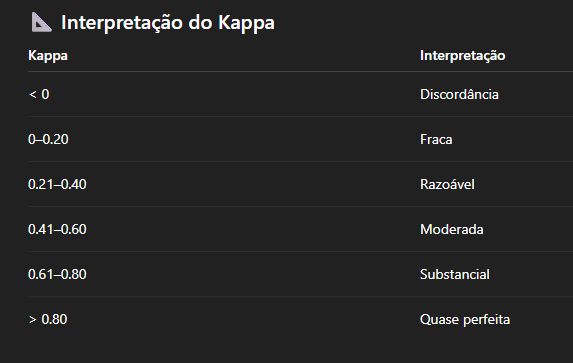

Nesse caso, a LLM não reproduziu fielmente o rótulo da base IBM, tendendo a superestimar lavagem (muitos falsos positivos).

Aconcordância observada é apenas marginalmente melhor que o acaso. 

Entretanto, também não podemos comparar diretamente com um classificador treinado supervisionadamente. Pois a LLM não foi treinada com essa base, não conhece a definição operacional de “Is Laundering” da IBM, não recebeu exemplos anteriores (zero-shot), não teve retroalimentação nem fine-tuning, ela apeans atua como avaliador heurístico baseado em linguagem.